In [5]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

In [6]:
class BasicGEMMExperiment:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")

    def benchmark_matmul(self, m, k, n, dtype=torch.float16, warmup_runs=5, timing_runs=10):
        # Create random matrices
        A = torch.randn(m, k, dtype=dtype, device=self.device)
        B = torch.randn(k, n, dtype=dtype, device=self.device)

        # Warmup
        for _ in range(warmup_runs):
            C = torch.matmul(A, B)
        if self.device == 'cuda':
            torch.cuda.synchronize()

        # Clear memory
        if self.device == 'cuda':
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()

        # Time operations
        times = []
        for _ in range(timing_runs):
            if self.device == 'cuda':
                torch.cuda.synchronize()
            start_time = time.perf_counter()
            C = torch.matmul(A, B)
            if self.device == 'cuda':
                torch.cuda.synchronize()
            end_time = time.perf_counter()
            times.append(end_time - start_time)

        # Calculate metrics
        avg_time = np.mean(times)
        operations = 2 * m * n * k
        gflops = operations / (avg_time * 1e9)
        memory_used = 0
        if self.device == 'cuda':
            memory_used = torch.cuda.max_memory_allocated() / (1024**3)

        # Cleanup
        del A, B, C
        if self.device == 'cuda':
            torch.cuda.empty_cache()

        return {
            'time_ms': avg_time * 1000,
            'gflops': gflops,
            'memory_gb': memory_used,
            'm': m, 'k': k, 'n': n
        }

    def benchmark_cpu_matmul(self, m, k, n, dtype=torch.float32, warmup_runs=5, timing_runs=10):
        # Create random matrices on CPU
        A = torch.randn(m, k, dtype=dtype, device='cpu')
        B = torch.randn(k, n, dtype=dtype, device='cpu')

        # Warmup
        for _ in range(warmup_runs):
            C = torch.matmul(A, B)

        # Time operations
        times = []
        for _ in range(timing_runs):
            start_time = time.perf_counter()
            C = torch.matmul(A, B)
            end_time = time.perf_counter()
            times.append(end_time - start_time)

        # Calculate metrics
        avg_time = np.mean(times)
        operations = 2 * m * n * k
        gflops = operations / (avg_time * 1e9)

        # Cleanup
        del A, B, C

        return {
            'time_ms': avg_time * 1000,
            'gflops': gflops,
            'memory_gb': 0,
            'm': m, 'k': k, 'n': n
        }

    def test_different_sizes(self, max_size=4096):
        sizes = []
        current_size = 32
        while current_size <= max_size:
            sizes.append(current_size)
            current_size *= 2
        results = []
        for size in sizes:
            print(f"{size}x{size}:", end="", flush=True)
            result = self.benchmark_matmul(size, size, size)
            result['size'] = size
            results.append(result)
            print(f"{result['gflops']:.1f} GFLOPS ({result['time_ms']:.1f} ms)")
        df = pd.DataFrame(results)
        print("\nResults:")
        print(df[['size', 'gflops', 'time_ms', 'memory_gb']])
        return df

    def test_cpu_sizes(self, max_size=4096):
        sizes = []
        current_size = 32
        while current_size <= max_size:
            sizes.append(current_size)
            current_size *= 2
        results = []
        for size in sizes:
            print(f"CPU {size}x{size}:", end="", flush=True)
            try:
                result = self.benchmark_cpu_matmul(size, size, size)
                result['size'] = size
                results.append(result)
                print(f"{result['gflops']:.1f} GFLOPS ({result['time_ms']:.1f} ms)")
            except Exception as e:
                print(f"Failed: {e}")
                break

        # Create DataFrame and display as simple table
        df = pd.DataFrame(results)
        print("\nCPU Results:")
        print(df[['size', 'gflops', 'time_ms']])
        return df

    def compare_cpu_gpu(self, cpu_max_size=4096, gpu_max_size=4096):
        # Test CPU first
        print("CPU performance")
        cpu_results = self.test_cpu_sizes(max_size=cpu_max_size)

        gpu_results = pd.DataFrame()
        if torch.cuda.is_available():
            print("\nGPU performance")
            gpu_results = self.test_different_sizes(max_size=gpu_max_size)

        return cpu_results, gpu_results

def plot_cpu_gpu_comparison(cpu_df, gpu_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Performance plot
    if not cpu_df.empty:
        ax1.loglog(cpu_df['size'], cpu_df['gflops'], 'o-', label='CPU', linewidth=2, markersize=8, color='red')
    if not gpu_df.empty:
        ax1.loglog(gpu_df['size'], gpu_df['gflops'], 's-', label='GPU', linewidth=2, markersize=8, color='blue')

    ax1.set_xlabel('Matrix Size (M = K = N)')
    ax1.set_ylabel('Performance (GFLOPS)')
    ax1.set_title('CPU vs GPU Performance Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Duration plot
    if not cpu_df.empty:
        ax2.loglog(cpu_df['size'], cpu_df['time_ms'], 'o-', label='CPU', linewidth=2, markersize=8, color='red')
    if not gpu_df.empty:
        ax2.loglog(gpu_df['size'], gpu_df['time_ms'], 's-', label='GPU', linewidth=2, markersize=8, color='blue')

    ax2.set_xlabel('Matrix Size (M = K = N)')
    ax2.set_ylabel('Duration (ms)')
    ax2.set_title('CPU vs GPU Duration Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_size_results(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    powers = [int(np.log2(size)) for size in df['size']]
    x_labels = [f'2^{p}' for p in powers]

    # Performance plot
    ax1.loglog(df['size'], df['gflops'], 'o-', linewidth=2, markersize=8)
    ax1.set_xlabel('Matrix Size (M = K = N)')
    ax1.set_ylabel('Performance (GFLOPS)')
    ax1.set_title('GEMM Performance vs Size')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(df['size'])
    ax1.set_xticklabels(x_labels)

    # Duration plot
    ax2.loglog(df['size'], df['time_ms'], 'o-', color='orange', linewidth=2, markersize=8)
    ax2.set_xlabel('Matrix Size (M = K = N)')
    ax2.set_ylabel('Duration (ms)')
    ax2.set_title('GEMM Duration vs Size')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(df['size'])
    ax2.set_xticklabels(x_labels)

    plt.tight_layout()
    plt.show()

def run_experiments():
    experiment = BasicGEMMExperiment()
    size_results = experiment.test_different_sizes(max_size=4096)
    plot_size_results(size_results)
    return size_results

def run_cpu_experiments():
    experiment = BasicGEMMExperiment()
    cpu_results = experiment.test_cpu_sizes(max_size=4096)
    plot_size_results(cpu_results)
    return cpu_results

def run_comparison_experiments():
    experiment = BasicGEMMExperiment()
    cpu_results, gpu_results = experiment.compare_cpu_gpu(cpu_max_size=4096, gpu_max_size=4096)
    plot_cpu_gpu_comparison(cpu_results, gpu_results)
    if not cpu_results.empty and not gpu_results.empty:
        common_sizes = set(cpu_results['size']) & set(gpu_results['size'])
        if common_sizes:
            for size in sorted(common_sizes):
                cpu_perf = cpu_results[cpu_results['size'] == size]['gflops'].iloc[0]
                gpu_perf = gpu_results[gpu_results['size'] == size]['gflops'].iloc[0]
                speedup = gpu_perf / cpu_perf
                print(f"Size {size:.1f}: CPU {cpu_perf:.1f} GFLOPS | GPU {gpu_perf:.1f} GFLOPS | Speedup: {speedup:.1f}x")

    return cpu_results, gpu_results

Using device: cuda
CPU performance
CPU 32x32:10.6 GFLOPS (0.0 ms)
CPU 64x64:30.8 GFLOPS (0.0 ms)
CPU 128x128:76.7 GFLOPS (0.1 ms)
CPU 256x256:86.4 GFLOPS (0.4 ms)
CPU 512x512:87.1 GFLOPS (3.1 ms)
CPU 1024x1024:87.0 GFLOPS (24.7 ms)
CPU 2048x2048:85.7 GFLOPS (200.4 ms)
CPU 4096x4096:80.1 GFLOPS (1715.9 ms)

CPU Results:
   size     gflops      time_ms
0    32  10.629126     0.006166
1    64  30.792290     0.017027
2   128  76.665284     0.054709
3   256  86.362770     0.388529
4   512  87.142455     3.080421
5  1024  87.043437    24.671402
6  2048  85.746043   200.357573
7  4096  80.096771  1715.911287

GPU performance
32x32:1.1 GFLOPS (0.1 ms)
64x64:9.9 GFLOPS (0.1 ms)
128x128:78.0 GFLOPS (0.1 ms)
256x256:627.3 GFLOPS (0.1 ms)
512x512:1925.1 GFLOPS (0.1 ms)
1024x1024:12521.9 GFLOPS (0.2 ms)
2048x2048:17477.9 GFLOPS (1.0 ms)
4096x4096:20770.6 GFLOPS (6.6 ms)

Results:
   size        gflops   time_ms  memory_gb
0    32      1.097575  0.059710   0.007942
1    64      9.912294  0.052893   

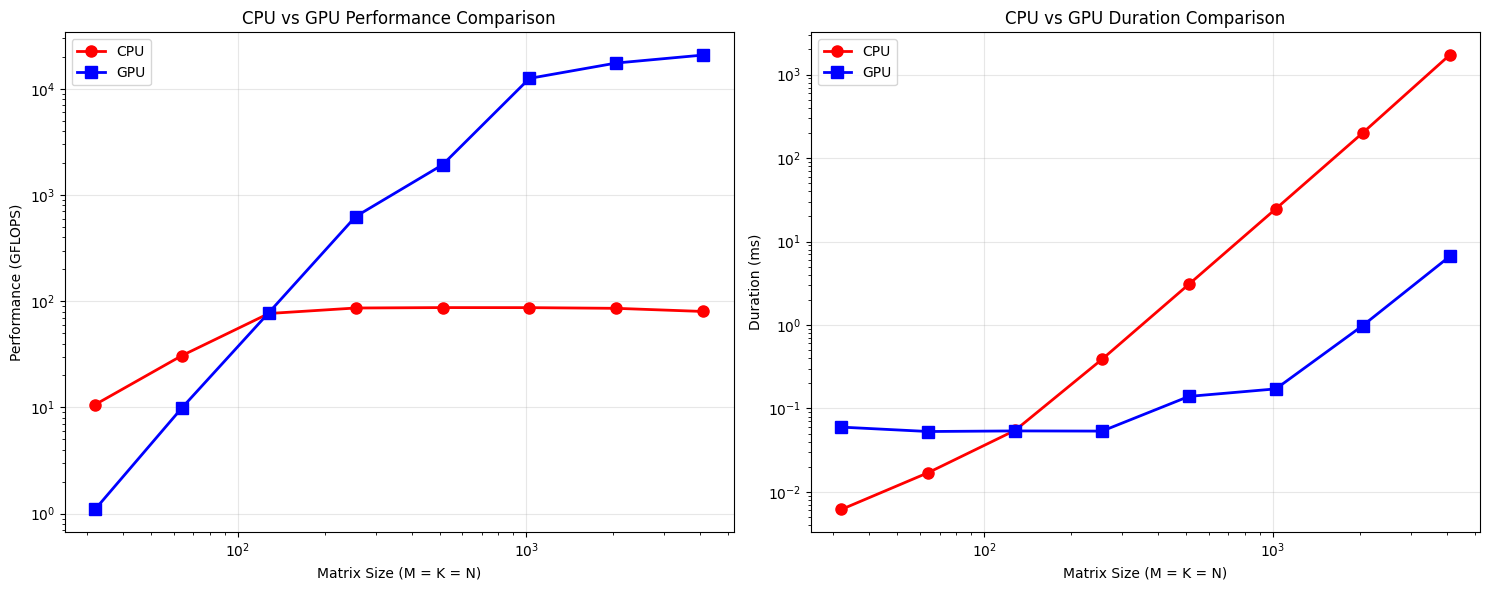

Size 32.0: CPU 10.6 GFLOPS | GPU 1.1 GFLOPS | Speedup: 0.1x
Size 64.0: CPU 30.8 GFLOPS | GPU 9.9 GFLOPS | Speedup: 0.3x
Size 128.0: CPU 76.7 GFLOPS | GPU 78.0 GFLOPS | Speedup: 1.0x
Size 256.0: CPU 86.4 GFLOPS | GPU 627.3 GFLOPS | Speedup: 7.3x
Size 512.0: CPU 87.1 GFLOPS | GPU 1925.1 GFLOPS | Speedup: 22.1x
Size 1024.0: CPU 87.0 GFLOPS | GPU 12521.9 GFLOPS | Speedup: 143.9x
Size 2048.0: CPU 85.7 GFLOPS | GPU 17477.9 GFLOPS | Speedup: 203.8x
Size 4096.0: CPU 80.1 GFLOPS | GPU 20770.6 GFLOPS | Speedup: 259.3x


In [7]:
# Run the comparison experiments
cpu_results, gpu_results = run_comparison_experiments()